# CAR Variance and Covariance Tests 
$$
\newcommand{\var}{\operatorname{var}}
\newcommand{\cov}{\operatorname{cov}}
\newcommand{\N}{\mathcal N}
$$

In [2]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
#import os
#os.chdir("/Users/mlysy/Documents/proj/buqDE/probDE")
#!python3 setup.py install
from BayesODE.Kalman.var_car import var_car
from BayesODE.Kalman.cov_car import cov_car
from BayesODE.Tests.root_gen import root_gen
from BayesODE.Tests.V_euler import V_euler

## Variance as a function of time

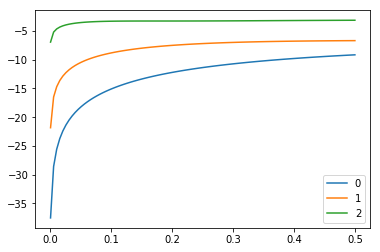

In [3]:
# quick picture
r0 = 1
p = 3
roots = root_gen(r0, p) #All roots need to be negative
tseq = np.linspace(0.001,0.5,100)
V = var_car(tseq, roots)
for k in range(len(roots)):
    plt.plot(tseq, np.log(V[:,k,k]), label=k)
plt.legend(loc='lower right')
plt.show()

In [10]:
# test against Euler

# car parameters
p = 3
r0 = np.random.uniform()
sigma = np.random.uniform()
roots = root_gen(r0, p)
# construct mOU process
#Gamma, Sigma = mou_car(roots = roots, sigma = sigma)

B = 10000
tval = np.array([1.])
N = 100
delta_t = tval/N
V_ex = var_car(tval, roots=roots, sigma=sigma) # exact variance
V_eu = V_euler(roots = roots,
               sigma = sigma,
               delta_t=delta_t, 
               N=N, 
               B=B, 
               X0=None)
np.allclose(V_ex, V_eu, atol=1e-2)


True

## Correlation as a function of time

First, let's calculate this analytically.  Suppose that the function `var_car` to compute $V_t = \var(X_t)$ is correct.  In fact what this is computing is $\var(X_t | X_0 = x_0)$, i.e., we condition on the value at $t = 0$ being fixed.  What we would like to compute with `cov_car` is $\cov(X_0, X_t)$ with $X_0 \sim \N(0, V_\infty)$ being drawn from its stationary distribution.

So we should modify the Euler simulation to draw the initial value randomly from this distribution.

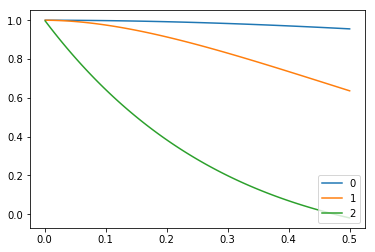

In [11]:
C = cov_car(tseq, roots, corr=True)
for k in range(len(roots)):
    plt.plot(tseq, C[:,k,k], label=k)
plt.legend(loc='lower right')
plt.show()

## Higher Order Solver

Let $y_t = (x^{(0)}_t, x^{(1)}_t, \ldots, x^{(q-1)}_t)$, such that the ODE is defined as

$$
a' y_t = F(y_t, t), \qquad y_0 = b,
$$

where $a_{q \times 1}$.  Note that this setup is somewhat flexible.  For instance you could use it to solve the ODE

$$
x^{(2)}_t + 2 x^{(1)}_t + \sin(x_t) + t = 0, \qquad x_0 = 2, \quad x^{(1)}_0 = 1.
$$

Then we could write

$$
a = (0, 1, 0), \quad F(y_t, t) = \frac{-x^{(2)}_t - \sin(x_t) - t}{2},
$$

or we could write

$$
a = (0, 2, 1), \quad F(y_t,t) = -\sin(x_t) - t.
$$

The solution prior is going to be on the CAR$(p)$ process $X_t = (x^{(0)}_t, \ldots, x^{(p-1)}_t)$ where $p > q$, such that the solution assumes at least $q-1$ continuous derivatives.

The algorithm goes like this:

1.  Let $X_0$ be compatible with $y_0 = c$.  I think a simple default is to assume that $X_0 \sim \N(0, V_{\infty})$, then condition on $y_0 = c$.  The first model interrogation is deterministic: $v_0^\star = F(y_0, 0)$ with variance $\Sigma_0^\star = 0$.
2.  Model interrogation:  Given that we have used the KF to store the mean and variance of $p(X_n \mid v_{0:n}^\star)$,
    - Do one forward step from Markov process $X_{n+1} \sim p(X_{n+1} \mid X_{0:n})$, via 
    
        $$
        X_n \sim p( \mid v_{0:n}^\star), \qquad X_{n+1} \sim p(X_{n+1} \mid X_n).
        $$
        
    - Interrogate $v_{n+1}^\star = F(y_{n+1}, t_{n+1})$, and calculate $\Sigma_{n+1}^\star = \var(a'y_{n+1} \mid v_{0:n}^{\star})$.
3.  Forward-pass update $p(X_{n+1} \mid v_{0:n+1}^\star)$, where the observation model is

    $$
    v_{n+1}^\star \sim \N(a'y_{n+1}, \Sigma_{n+1}^\star),
    $$
        
    where $y_{n+1}$ are the first $p+1$ elements of $X_{n+1}$.
4.  Once you've done this for $N$ steps, backward-pass update (KF smoothing) to get $p(X_{0:N} \mid v_{0:N}^{\star})$. 

# Unit Test

In [13]:
r0 = 1
roots = root_gen(r0, 3)

delta = -roots
D = np.diag(delta)
p = len(roots)
Q = np.zeros((p, p))

row = np.ones(p)
for i in range(p):
    Q[i] = row
    row = row*roots

Q_inv = np.linalg.pinv(Q)
Gamma = np.linalg.multi_dot([Q, D, Q_inv])

In [14]:
from sympy import symbols, expand, Poly
s = symbols('s')
product = 1
for root in roots:
    product = product * (s - root)
coeffs = Poly(expand(product)).coeffs()
np.allclose(np.array(coeffs[:0:-1], dtype='float'),Gamma[-1])

True

In [15]:
def V_euler_N1(Sigma, Delta_t):
    return Sigma*Delta_t

In [16]:
def var_car_test(Q, D, Sigma, Delta_t):
    p = len(D)
    delta = np.diag(D)
    Q_inv = np.linalg.pinv(Q)
    Gamma = np.linalg.multi_dot([Q, D, Q_inv]) #Q*D*Q^-1
    Sigma_tilde = np.linalg.multi_dot([Q_inv, Sigma, Q_inv.T]) #Q^-1*Sigma*Q^-1'

    V_tilde = np.zeros((p,p))
    for i in range(p):
        for j in range(i, p):
            V_tilde[i,j] = Sigma_tilde[i,j] / (delta[i] + delta[j]) * (1- exp(- (delta[i] + delta[j]) * Delta_t)) #V_tilde
            V_tilde[j,i] = V_tilde[i,j]

    V = np.linalg.multi_dot([Q, V_tilde, Q.T]) #V_deltat
    return V

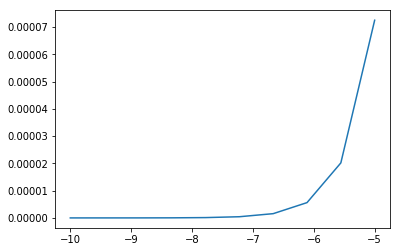

In [17]:
Delta_T = 10**-np.linspace(5, 10, 10)
Q = np.ones((3,3))
D = np.diag([1,2,3])
Sigma = np.random.rand(3,3)
Sigma = Sigma.dot(Sigma.T)

compare = np.zeros(len(Delta_T))
for t in range(len(Delta_T)):
    euler = V_euler_N1(Sigma, Delta_T[t])
    true = var_car_test(Q, D, Sigma, Delta_T[t])
    compare[t] = np.max((abs(euler - true)/(abs(euler) + 0.1)))
    
plt.plot(np.log10(Delta_T), compare)